Populating the interactive namespace from numpy and matplotlib
3756
Minimum Square Error 0    0.012268
dtype: float64
R-Square: 0.315375346327
In the movie data, 642 out of 3756 directors_facebook_like are 0
In the movie data, 1742 out of 3756 movie_facebook_like are 0
Minimum Square Error with few numeric 0    0.012051
dtype: float64
R-Square with few numeric: 0.293155387722
Good:  (939, 1)
Minimum Square Error with numeric+text 0    1.989880e+21
dtype: float64
R-Square with numeric+text: -1.0958897869e+23


`%matplotlib` prevents importing * from pylab and numpy
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data

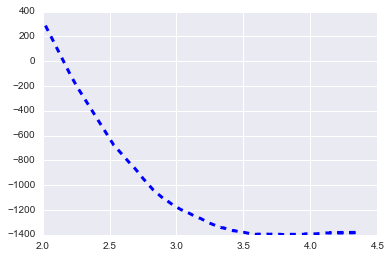

0.000153890466253
good:  (939,)
Rsq Lasso:  0.472488618181
Random Forest:  0.494423961661
Rsq RF:  0.565490863551
['num_voted_users', u'genres_drama', 'budget', 'duration', 'num_user_for_reviews', 'gross', 'director_facebook_likes', 'cast_total_facebook_likes', 'num_critic_for_reviews', 'profit']


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import Preprocessor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, preprocessing, cross_validation
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

def token(text):
    return(text.split("|"))

def scaler(data,target):
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    target = pd.DataFrame(scaler.fit_transform(target))
    return data,target

%pylab inline
#Reading from csv and Cleaning
imdb_movie = Preprocessor.data
imdb_movie['profit'] = imdb_movie['gross'] - imdb_movie['budget']

print len(imdb_movie)

#Plotting histogram for imdb_score
imdb_score = imdb_movie['imdb_score']
# plt.hist(imdb_score,bins=20)
# plt.show()

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)
# print target

# #Correlation Plot
# corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# plt.figure(figsize=(12, 12))
# sns.heatmap(corr, vmax=1, square=True)
# plt.show()


xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

#First step: Using Simple Linear Regression
model = LinearRegression()
model.fit(xtrain,ytrain)
pred = model.predict(xtest)
mse = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error', mse
print 'R-Square:', model.score(xtest,ytest)

# #Scatter plots
# plt.figure(figsize=(7,10))
# for i in range(len(list_fig)):
#     plt.subplot(8,2,i+1)
#     plt.title(list_fig[i])
#     plt.scatter(target,data[list_fig[i]],marker='x',color='r',label='dir_score')    
# plt.tight_layout()
# plt.show()

#------------------------------------------------
imdb_movie_dir = imdb_movie[imdb_movie['director_facebook_likes']==0]
print 'In the movie data,',imdb_movie_dir.shape[0],'out of', imdb_movie.shape[0],'directors_facebook_like are 0'

imdb_movie_ml = imdb_movie[imdb_movie['movie_facebook_likes']==0]
print 'In the movie data,',imdb_movie_ml.shape[0],'out of', imdb_movie.shape[0],'movie_facebook_like are 0'

#Second Step: Removing Few Numerical Features
remove_list = ['director_facebook_likes','movie_facebook_likes','cast_total_facebook_likes']
for rm in remove_list:
    list_fig.remove(rm)

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)

xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

model_2 = LinearRegression()
model_2.fit(xtrain,ytrain)
pred = model_2.predict(xtest)
mse2 = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error with few numeric', mse2
print 'R-Square with few numeric:', model_2.score(xtest,ytest)
    
#------------------------------------------------    

#Third step: Including text/categorical feature

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list

xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.75)

model_3 = LinearRegression()
model_3.fit(xtrain,ytrain)
pred = model_3.predict(xtest)
mse3 = np.mean((pred - ytest) ** 2)
print 'Good: ', pred.shape
print 'Minimum Square Error with numeric+text', mse3
print 'R-Square with numeric+text:', model_3.score(xtest,ytest)

#--------------------------------------------------
list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

# data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
# targetcol = 'imdb_score'

# data,target = scaler(data,target)

data = imdb_movie[list_fig]
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
target = imdb_movie['imdb_score']

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list


xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.75)

aic_m = LassoLarsIC(criterion='aic')
aic_m.fit(xtrain, ytrain)
alphas_ = aic_m.alphas_
criterion_ = aic_m.criterion_
plt.plot(-np.log10(alphas_), criterion_, '--', color='b',
             linewidth=3)
plt.show()
print aic_m.alpha_

model_L = Lasso(alpha=aic_m.alpha_)
model_L.fit(xtrain,ytrain)
ypred = model_L.predict(xtest)
mse2 = np.sqrt(np.sum((ypred - ytest) ** 2))
rsq = model_L.score(xtest,ytest)
print 'good: ',ypred.shape
print 'Rsq Lasso: ', rsq
mse2

rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
pred_rf = rf.predict(xtest)
mse4 = np.mean((pred_rf - ytest) ** 2)
print 'Random Forest: ',mse4
rsq1 = rf.score(xtest,ytest)
indices = np.argsort(rf.feature_importances_)[::-1]
top10 = indices[0:10]

print 'Rsq RF: ', rsq1
f=[]
for i in top10:
    f.append(new_coeff_list[i])
    
print f


Populating the interactive namespace from numpy and matplotlib
Index([u'Steven Spielberg', u'Ridley Scott', u'Tim Burton', u'Clint Eastwood',
       u'Christopher Nolan', u'Steven Soderbergh', u'Peter Jackson',
       u'Martin Scorsese', u'Sam Raimi', u'Zack Snyder', u'David Fincher',
       u'Woody Allen', u'Sam Mendes', u'Michael Bay', u'Quentin Tarantino',
       u'Danny Boyle', u'Ethan Coen', u'Ron Howard', u'Bryan Singer',
       u'Robert Zemeckis'],
      dtype='object', name=u'director_name')


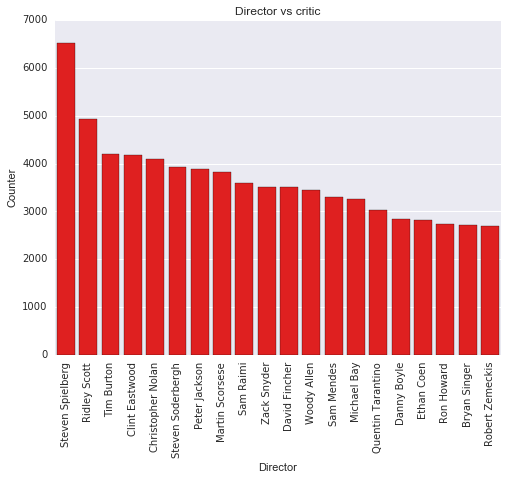

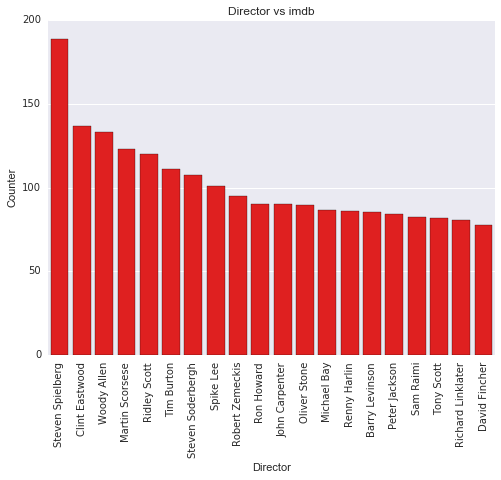

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%pylab inline
#Reading from csv
imdb_movie_base = pd.read_csv('C:/Users/schttrj1/Desktop/CompBackup/Courses_Fall_2016/Data_Science_Appln/Final Project/movie_metadata.csv')

#Cleaning the data
imdb_movie = imdb_movie_base.dropna(axis=0)    

#Director v Critic
director_tot = imdb_movie.groupby(imdb_movie['director_name'])['num_critic_for_reviews'].sum()
dir_names = director_tot.sort_values(ascending=False)[:20].index
dir_critic = director_tot.sort_values(ascending=False)[:20].values
print dir_names
fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x = dir_names,
            y = dir_critic,
            color='r')
ticks = plt.setp(ax.get_xticklabels(),rotation=90)
plt.title('Director vs critic')
plt.ylabel('Counter')
plt.xlabel('Director')

#Director v imdb
director_tot_ = imdb_movie.groupby(imdb_movie['director_name'])['imdb_score'].sum()
dir_names_ = director_tot_.sort_values(ascending=False)[:20].index
dir_critic_ = director_tot_.sort_values(ascending=False)[:20].values

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x = dir_names_,
            y = dir_critic_,
            color='r')
ticks = plt.setp(ax.get_xticklabels(),rotation=90)
plt.title('Director vs imdb')
plt.ylabel('Counter')
plt.xlabel('Director')


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale,MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns

%pylab inline
#Reading from csv
imdb_movie_base = pd.read_csv('C:/Users/schttrj1/Desktop/CompBackup/Courses_Fall_2016/Data_Science_Appln/Final Project/movie_metadata.csv')
imdb_movie_base['profit'] = imdb_movie_base['gross'] - imdb_movie_base['budget']

#Cleaning the data
imdb_movie = imdb_movie_base.dropna(axis=0)
print len(imdb_movie)

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

data = imdb_movie[list_fig]
target = imdb_movie['imdb_score']
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
IMDB_best2 = SelectKBest(f_regression, k=10).fit_transform(data, target) 
print IMDB_best2.itemset
target = imdb_movie['imdb_score']
# print data

Populating the interactive namespace from numpy and matplotlib
3756
<built-in method itemset of numpy.ndarray object at 0x19DA5098>


Populating the interactive namespace from numpy and matplotlib
3756
Minimum Square Error 0    0.013006
dtype: float64
R-Square: 0.311289997112
In the movie data, 642 out of 3756 directors_facebook_like are 0
In the movie data, 1742 out of 3756 movie_facebook_like are 0
Minimum Square Error with few numeric 0    0.015609
dtype: float64
R-Square with few numeric: 0.249775250022
Good:  (939, 1)
Minimum Square Error with numeric+text 0    0.010099
dtype: float64
R-Square with numeric+text: 0.456875957038


C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

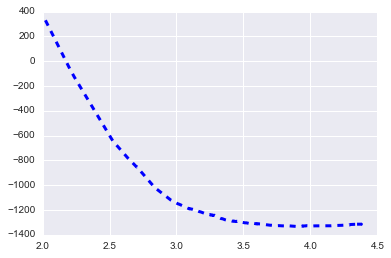

0.000125399420916
good:  (939,)
Rsq Lasso:  0.425516959253
Random Forest:  0.509166773163
Rsq RF:  0.532169427009
['num_voted_users', u'genres_drama', 'budget', 'num_user_for_reviews', 'duration', 'gross', 'actor_3_facebook_likes', 'director_facebook_likes', 'cast_total_facebook_likes', 'profit']


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import Preprocessor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, preprocessing, cross_validation
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

def token(text):
    return(text.split("|"))

def scaler(data,target):
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    target = pd.DataFrame(scaler.fit_transform(target))
    return data,target

%pylab inline
#Reading from csv and Cleaning
imdb_movie = Preprocessor.data
imdb_movie['profit'] = imdb_movie['gross'] - imdb_movie['budget']

print len(imdb_movie)

#Plotting histogram for imdb_score
imdb_score = imdb_movie['imdb_score']
# plt.hist(imdb_score,bins=20)
# plt.show()

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)
# print target

# #Correlation Plot
# corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# plt.figure(figsize=(12, 12))
# sns.heatmap(corr, vmax=1, square=True)
# plt.show()


xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

#First step: Using Simple Linear Regression
model = LinearRegression()
model.fit(xtrain,ytrain)
pred = model.predict(xtest)
mse = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error', mse
print 'R-Square:', model.score(xtest,ytest)

# #Scatter plots
# plt.figure(figsize=(7,10))
# for i in range(len(list_fig)):
#     plt.subplot(8,2,i+1)
#     plt.title(list_fig[i])
#     plt.scatter(target,data[list_fig[i]],marker='x',color='r',label='dir_score')    
# plt.tight_layout()
# plt.show()

#------------------------------------------------
imdb_movie_dir = imdb_movie[imdb_movie['director_facebook_likes']==0]
print 'In the movie data,',imdb_movie_dir.shape[0],'out of', imdb_movie.shape[0],'directors_facebook_like are 0'

imdb_movie_ml = imdb_movie[imdb_movie['movie_facebook_likes']==0]
print 'In the movie data,',imdb_movie_ml.shape[0],'out of', imdb_movie.shape[0],'movie_facebook_like are 0'

#Second Step: Removing Few Numerical Features
remove_list = ['director_facebook_likes','movie_facebook_likes','cast_total_facebook_likes']
for rm in remove_list:
    list_fig.remove(rm)

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)

xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

model_2 = LinearRegression()
model_2.fit(xtrain,ytrain)
pred = model_2.predict(xtest)
mse2 = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error with few numeric', mse2
print 'R-Square with few numeric:', model_2.score(xtest,ytest)
    
#------------------------------------------------    

#Third step: Including text/categorical feature

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list

xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.75)

model_3 = LinearRegression()
model_3.fit(xtrain,ytrain)
pred = model_3.predict(xtest)
mse3 = np.mean((pred - ytest) ** 2)
print 'Good: ', pred.shape
print 'Minimum Square Error with numeric+text', mse3
print 'R-Square with numeric+text:', model_3.score(xtest,ytest)

#--------------------------------------------------
list_fig = ['num_voted_users', 'budget', 'num_user_for_reviews', 'duration', 'actor_3_facebook_likes', 
            'gross', 'director_facebook_likes', 'profit', 'cast_total_facebook_likes']

# data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
# targetcol = 'imdb_score'

# data,target = scaler(data,target)

data = imdb_movie[list_fig]
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
target = imdb_movie['imdb_score']

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list


xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.75)

aic_m = LassoLarsIC(criterion='aic')
aic_m.fit(xtrain, ytrain)
alphas_ = aic_m.alphas_
criterion_ = aic_m.criterion_
plt.plot(-np.log10(alphas_), criterion_, '--', color='b',
             linewidth=3)
plt.show()
print aic_m.alpha_

model_L = Lasso(alpha=aic_m.alpha_)
model_L.fit(xtrain,ytrain)
ypred = model_L.predict(xtest)
mse2 = np.sqrt(np.sum((ypred - ytest) ** 2))
rsq = model_L.score(xtest,ytest)
print 'good: ',ypred.shape
print 'Rsq Lasso: ', rsq
mse2

rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
pred_rf = rf.predict(xtest)
mse4 = np.mean((pred_rf - ytest) ** 2)
print 'Random Forest: ',mse4
rsq1 = rf.score(xtest,ytest)
indices = np.argsort(rf.feature_importances_)[::-1]
top10 = indices[0:10]

print 'Rsq RF: ', rsq1
f=[]
for i in top10:
    f.append(new_coeff_list[i])
    
print f